In [0]:
import sqlite3
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

In [1]:
def drop_tweets_before_cleaning_table(db_name='Twitter_Final_DB.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS cleaned_tweets;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("Tweets_before_cleaning Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_tweets_before_cleaning_table()

Tweets_before_cleaning Table deleted from Twitter_Final_DB.


In [2]:
def drop_Users_before_cleaning_table(db_name='Twitter_Final_DB.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Users_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS cleaned_users;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("Users_before_cleaning Table deleted from Twitter_Final_DB.")

# Call the function to delete the Users_before_cleaning
drop_Users_before_cleaning_table()

Users_before_cleaning Table deleted from Twitter_Final_DB.


In [3]:
# Path to the directory containing JSON files
data_dir = r"C:\Users\20232015\Downloads\data\data"

def create_database_schema(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    table_creation_queries = [
        '''
        CREATE TABLE IF NOT EXISTS cleaned_tweets (
            created_at TEXT,
            id_str TEXT PRIMARY KEY,
            text TEXT,
            source TEXT,
            in_reply_to_status_id_str TEXT,
            in_reply_to_user_id_str TEXT,
            in_reply_to_screen_name TEXT,
            user TEXT,
            place TEXT,
            is_quote_status BOOLEAN,
            quote_count INTEGER,
            reply_count INTEGER,
            retweet_count INTEGER,
            favorite_count INTEGER,
            favorited BOOLEAN,
            retweeted BOOLEAN,
            lang TEXT,
            quoted_status_id_str TEXT,
            quoted_status_created_at TEXT,
            quoted_status_text TEXT
        )
        ''',
        '''
        CREATE TABLE IF NOT EXISTS cleaned_users (
            id_str TEXT PRIMARY KEY,
            name TEXT,
            screen_name TEXT,
            location TEXT,
            url TEXT,
            description TEXT,
            protected BOOLEAN,
            verified BOOLEAN,
            followers_count INTEGER,
            friends_count INTEGER,
            listed_count INTEGER,
            favourites_count INTEGER,
            statuses_count INTEGER,
            created_at TEXT,
            geo_enabled BOOLEAN,
            contributors_enabled BOOLEAN,
            is_translator BOOLEAN
        )
        '''
    ]

    for query in table_creation_queries:
        cursor.execute(query)

    connection.commit() 
    connection.close()

    print("Database schema updated successfully.")

def populate_database_from_json(db_name='Twitter_database_v3.db', data_dir=data_dir):
    print(f"Data directory path: {data_dir}")

    if not os.path.exists(data_dir):
        print(f"Data directory does not exist: {data_dir}")
        return

    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            print(f"Processing file: {file_path}")
    
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        data = json.loads(line)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {filename}: {e}")
                        continue
    
                    if 'created_at' in data and 'id_str' in data and ('text' in data or 'full_text' in data):
                        quoted_status_id_str = None
                        quoted_status_created_at = None
                        quoted_status_text = None
    
                        if data.get('is_quote_status') and 'quoted_status' in data:
                            quoted_status_id_str = data['quoted_status'].get('id_str')
                            quoted_status_created_at = data['quoted_status'].get('created_at')
                            quoted_status_text = data['quoted_status'].get('text') if data['quoted_status'].get('full_text') is None else data['quoted_status'].get('full_text')
    
                        cursor.execute('''
                        INSERT OR IGNORE INTO cleaned_tweets (
                            created_at, id_str, text, source, in_reply_to_status_id_str, 
                            in_reply_to_user_id_str, in_reply_to_screen_name, user, place, is_quote_status, 
                            quote_count, reply_count, retweet_count, favorite_count, favorited, retweeted, 
                            lang, quoted_status_id_str, quoted_status_created_at, quoted_status_text
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            data.get('created_at'), data.get('id_str'),
                            data.get('text') if data.get('full_text') is None else data.get('full_text'),
                            data.get('source'), data.get('in_reply_to_status_id_str'),
                            data.get('in_reply_to_user_id_str'), data.get('in_reply_to_screen_name'), json.dumps(data.get('user')),
                            json.dumps(data.get('place')), data.get('is_quote_status'), data.get('quote_count'), data.get('reply_count'), data.get('retweet_count'), data.get('favorite_count'),
                            data.get('favorited'), data.get('retweeted'), data.get('lang'),
                            quoted_status_id_str, quoted_status_created_at, quoted_status_text
                        ))

                        user = data.get('user')
                        if user:
                            cursor.execute('''
                            INSERT OR IGNORE INTO cleaned_users (
                                id_str, name, screen_name, location, url, description, protected, 
                                verified, followers_count, friends_count, listed_count, favourites_count, 
                                statuses_count, created_at, geo_enabled, contributors_enabled, is_translator
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                            ''', (
                                user.get('id_str'), user.get('name'), user.get('screen_name'), user.get('location'),
                                user.get('url'), user.get('description'), user.get('protected'), user.get('verified'),
                                user.get('followers_count'), user.get('friends_count'), user.get('listed_count'), user.get('favourites_count'),
                                user.get('statuses_count'), user.get('created_at'), user.get('geo_enabled'), 
                                user.get('contributors_enabled'), user.get('is_translator')
                            ))

    connection.commit()
    connection.close()

    print("Database populated successfully from JSON files.")

    # Print the absolute path of the database file
    db_path = os.path.abspath(db_name)
    print(f"Database file path: {db_path}")



In [4]:
create_database_schema(db_name='Twitter_database_v3.db')

Database schema updated successfully.


In [5]:
populate_database_from_json()

Data directory path: C:\Users\20232015\Downloads\data\data
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558527599826.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558546003827.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558611772040.json
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 col

In [6]:
populate_database_from_json(data_dir=data_dir)

Data directory path: C:\Users\20232015\Downloads\data\data
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558527599826.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558546003827.json
Processing file: C:\Users\20232015\Downloads\data\data\airlines-1558611772040.json
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 column 1 (char 0)
Error decoding JSON from file airlines-1558611772040.json: Expecting value: line 1 col

In [7]:
def create_conversations_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    conversations_table_query = [
        '''
    CREATE TABLE IF NOT EXISTS conversations_table AS
SELECT
    created_at,
    id_str,
    text,
    in_reply_to_status_id_str,
    in_reply_to_user_id_str,
    in_reply_to_screen_name,
    user,
    1 AS is_quote_status,
    json_extract(extended_tweet, '$.full_text') AS extended_tweet_full_text,
    quote_count,
    reply_count,
    favorite_count,
    retweet_count,
    lang,
    (SELECT text FROM Tweets_before_cleaning WHERE id_str = t.in_reply_to_status_id_str) AS original_tweet_text
    FROM
    (SELECT * FROM Tweets_before_cleaning WHERE is_quote_status = 1 LIMIT 100) AS t;
            
        '''
   ]
    
    cursor.execute(conversations_table_query)
    connection.commit()
    connection.close()

    print("Conversations Table added to Twitter_Final_DB. Database has been Updated.")

In [8]:
# Path to the database
db_name = 'Twitter_database_v3.db'

# Connect to the SQLite database
connection = sqlite3.connect(db_name)
cursor = connection.cursor()

# SQL query to create the new table with Virgin Atlantic related tweets
create_table_query = '''
CREATE TABLE IF NOT EXISTS virgin_atlantic_tweets AS
SELECT *
FROM cleaned_tweets
WHERE text LIKE '%Virgin Atlantic%' OR text LIKE '%@VirginAtlantic%' 
OR json_extract(user, '$.screen_name') = 'VirginAtlantic';
'''

# Execute the query
cursor.execute(create_table_query)

# Commit the changes and close the connection
connection.commit()
connection.close()

print("Table 'virgin_atlantic_tweets' created successfully with relevant tweets.")


Table 'virgin_atlantic_tweets' created successfully with relevant tweets.


(-1.099999763658255,
 1.099999623093575,
 -1.0999996260209135,
 1.0999997567847757)

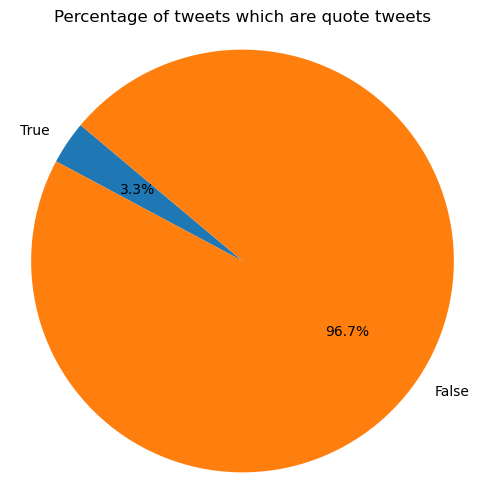

In [9]:
db_path = 'Twitter_database_v3.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM virgin_atlantic_tweets", conn)
conn.close()

true_count = df['is_quote_status'].sum()
false_count = len(df) - true_count
counts = {'True_Count': true_count, 'False_Count': false_count}

labels = ['True', 'False']
sizes = [counts['True_Count'], counts['False_Count']]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Percentage of tweets which are quote tweets')
plt.axis('equal')

In [10]:
def create_conversations_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    conversations_table_query = '''
    CREATE TABLE IF NOT EXISTS conversations_table AS
    SELECT
        t.created_at,
        t.id_str,
        t.text,
        t.in_reply_to_status_id_str,
        t.in_reply_to_user_id_str,
        t.in_reply_to_screen_name,
        t.user,
        t.is_quote_status,
        t.quote_count,
        t.reply_count,
        t.favorite_count,
        t.retweet_count,
        t.lang,
        t.quoted_status_id_str,
        t.quoted_status_created_at,
        t.quoted_status_text,
        (SELECT text FROM cleaned_tweets WHERE id_str = t.in_reply_to_status_id_str) AS original_tweet_text
    FROM
        cleaned_tweets AS t
    WHERE
        t.is_quote_status IS NOT "0" OR t.in_reply_to_status_id_str IS NOT NULL
    '''

    cursor.execute(conversations_table_query)
    connection.commit()
    connection.close()

    print("Conversations Table added to the database. Database has been updated.")

create_conversations_table()

Conversations Table added to the database. Database has been updated.


In [11]:
def drop_influencer_tweets_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE IF EXISTS influencer_tweets;
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("influencer tweets Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_influencer_tweets_table()

influencer tweets Table deleted from Twitter_Final_DB.


In [12]:
def create_influencer_tweets_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    influencer_tweets_query = '''
    CREATE TABLE IF NOT EXISTS influencer_tweets AS
    SELECT *
    FROM virgin_atlantic_tweets
    WHERE json_extract(user, '$.verified') = 1
    AND json_extract(user, '$.followers_count') > 25000
    AND json_extract(user, '$.screen_name') != 'VirginAtlantic';
    '''

    cursor.execute(influencer_tweets_query)
    connection.commit()
    connection.close()

    print("Influencer Tweets Table created successfully.")

# Call the function to create the influencer_tweets table
create_influencer_tweets_table()


Influencer Tweets Table created successfully.


Response Times Table created successfully.
Average response time to influencers: nan minutes
Average response time to normal users: nan minutes


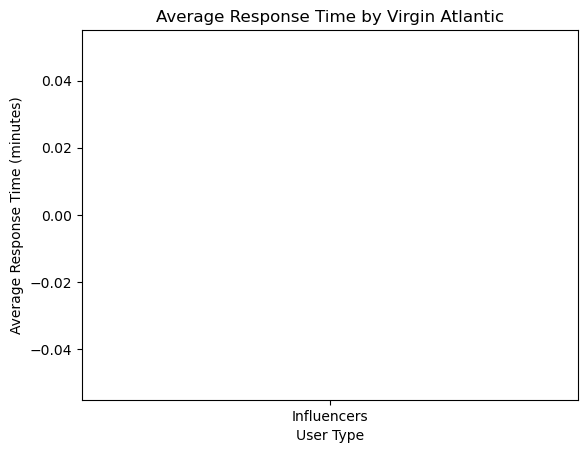

In [13]:
def create_response_times_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # Create the response_times table from conversations_table
    response_times_query = '''
    CREATE TABLE IF NOT EXISTS response_times AS
    SELECT
        t1.id_str AS reply_id,
        t1.created_at AS reply_created_at,
        t2.id_str AS original_tweet_id,
        t2.created_at AS original_tweet_created_at,
        t2.user AS original_tweet_user,
        (julianday(t1.created_at) - julianday(t2.created_at)) * 24 * 60 AS response_time_minutes
    FROM
        conversations_table AS t1
    JOIN
        conversations_table AS t2
    ON
        t1.in_reply_to_status_id_str = t2.id_str
    WHERE
        json_extract(t1.user, '$.screen_name') = 'VirginAtlantic';
    '''
    
    cursor.execute(response_times_query)
    connection.commit()
    connection.close()

    print("Response Times Table created successfully.")

def calculate_and_plot_average_response_times(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # Query the response times
    query = '''
    SELECT
        original_tweet_user,
        response_time_minutes,
        json_extract(original_tweet_user, '$.verified') AS is_verified,
        json_extract(original_tweet_user, '$.followers_count') AS followers_count
    FROM
        response_times
    '''
    
    df = pd.read_sql_query(query, connection)
    connection.close()

    # Define influencers as verified users with more than 25k followers
    df['is_influencer'] = df.apply(lambda row: row['is_verified'] == 1 and row['followers_count'] > 25000, axis=1)

    # Calculate average response times
    average_response_time_influencers = df[df['is_influencer']]['response_time_minutes'].mean()
    average_response_time_normal_users = df[~df['is_influencer']]['response_time_minutes'].mean()

    # Print the average response times
    print(f"Average response time to influencers: {average_response_time_influencers} minutes")
    print(f"Average response time to normal users: {average_response_time_normal_users} minutes")

    # Plot the average response times
    categories = ['Influencers', 'Normal Users']
    average_times = [average_response_time_influencers, average_response_time_normal_users]

    plt.bar(categories, average_times, color=['blue', 'green'])
    plt.xlabel('User Type')
    plt.ylabel('Average Response Time (minutes)')
    plt.title('Average Response Time by Virgin Atlantic')
    plt.show()

# Create the response_times table from conversations_table
create_response_times_table()

# Calculate, print, and plot the average response times
calculate_and_plot_average_response_times()


In [14]:
def drop_response_table(db_name='Twitter_database_v3.db'):
    connection = sqlite3.connect(db_name)
    cursor = connection.cursor()

    # SQL query to drop the Tweets_before_cleaning
    drop_table_query = '''
    DROP TABLE response_times
    '''

    cursor.execute(drop_table_query)
    connection.commit()
    connection.close()

    print("influencer tweets Table deleted from Twitter_Final_DB.")

# Call the function to delete the Tweets_before_cleaning
drop_response_table()

influencer tweets Table deleted from Twitter_Final_DB.


In [15]:
def process_replies_and_quotes(db_name='twitter_database_v3.db', table_name='conversations_table'):
    start_time = time.time()

    conn = sqlite3.connect(db_name)

    # Load data from the specified table into a pandas DataFrame
    print(f"Loading data from {table_name}...")
    conversations_query = f"""
    SELECT 
        created_at, 
        id_str, 
        in_reply_to_status_id_str,
        json_extract(user, '$.id_str') AS user_id_str,
        quoted_status_created_at
    FROM 
        {table_name}
    """
    conversations_df = pd.read_sql_query(conversations_query, conn)

    # Load data from cleaned_tweets into a pandas DataFrame
    print("Loading data from cleaned_tweets...")
    cleaned_tweets_query = """
    SELECT 
        created_at AS in_reply_to_created_at,
        id_str
    FROM 
        cleaned_tweets
    """
    cleaned_tweets_df = pd.read_sql_query(cleaned_tweets_query, conn)

    # Close the database connection
    conn.close()

    # Convert to datetime
    conversations_df['created_at'] = pd.to_datetime(conversations_df['created_at'])
    conversations_df['quoted_status_created_at'] = pd.to_datetime(conversations_df['quoted_status_created_at'])
    cleaned_tweets_df['in_reply_to_created_at'] = pd.to_datetime(cleaned_tweets_df['in_reply_to_created_at'])

    # Merge the dataframes to add in_reply_to_created_at column
    merged_df = conversations_df.merge(cleaned_tweets_df, left_on='in_reply_to_status_id_str', right_on='id_str', how='left', suffixes=('', '_reply'))

    # Calculate the time differences
    merged_df['time_diff_quoted'] = (merged_df['created_at'] - merged_df['quoted_status_created_at']).dt.total_seconds()
    merged_df['time_diff_reply'] = (merged_df['created_at'] - merged_df['in_reply_to_created_at']).dt.total_seconds()

    # Filter the time differences to be outside -1 to +1 seconds
    time_diff_quoted_filtered = merged_df[(merged_df['time_diff_quoted'] <= -1) | (merged_df['time_diff_quoted'] >= 1)]
    time_diff_reply_filtered = merged_df[(merged_df['time_diff_reply'] <= -1) | (merged_df['time_diff_reply'] >= 1)]

    # Create dictionaries for time differences
    time_diff_quoted_dict = time_diff_quoted_filtered.set_index('id_str')['time_diff_quoted'].to_dict()
    time_diff_reply_dict = time_diff_reply_filtered.set_index('id_str')['time_diff_reply'].to_dict()

    end_time = time.time()
    print(f"Total time taken to run for {table_name}: {end_time - start_time} seconds\n")

    return time_diff_quoted_dict, time_diff_reply_dict

# Call the function for each table
time_diff_quoted_dict_conversations, time_diff_reply_dict_conversations = process_replies_and_quotes(table_name='conversations_table')
time_diff_quoted_dict_influencers, time_diff_reply_dict_influencers = process_replies_and_quotes(table_name='influencer_tweets')
time_diff_quoted_dict_virgin, time_diff_reply_dict_virgin = process_replies_and_quotes(table_name='virgin_atlantic_tweets')

# Function to print the first key-value pair of a dictionary
def print_first_kv_pair(dictionary, dict_name):
    if dictionary:
        first_key = next(iter(dictionary))
        print(f"First key-value pair of {dict_name}: {first_key}: {dictionary[first_key]}")
    else:
        print(f"{dict_name} is empty.")

# Print the first key-value pair of each dictionary
print_first_kv_pair(time_diff_quoted_dict_conversations, 'Quoted Status Time Differences (Conversations)')
print_first_kv_pair(time_diff_reply_dict_conversations, 'Reply Status Time Differences (Conversations)')
print_first_kv_pair(time_diff_quoted_dict_influencers, 'Quoted Status Time Differences (Influencers)')
print_first_kv_pair(time_diff_reply_dict_influencers, 'Reply Status Time Differences (Influencers)')
print_first_kv_pair(time_diff_quoted_dict_virgin, 'Quoted Status Time Differences (Virgin Atlantic)')
print_first_kv_pair(time_diff_reply_dict_virgin, 'Reply Status Time Differences (Virgin Atlantic)')

def plot_time_differences(time_diff_dict, title, filename):
    # Convert the time differences from timedelta to seconds
    time_diff_seconds = list(time_diff_dict.values())

    # Plot histogram for time differences
    plt.figure(figsize=(10, 6))
    plt.hist(time_diff_seconds, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Plot and save histograms for each dictionary
plot_time_differences(time_diff_quoted_dict_conversations, 'Time Difference for Quoted Status (Conversations)', 'time_diff_quoted_conversations.png')
plot_time_differences(time_diff_reply_dict_conversations, 'Time Difference for Reply Status (Conversations)', 'time_diff_reply_conversations.png')
plot_time_differences(time_diff_quoted_dict_influencers, 'Time Difference for Quoted Status (Influencers)', 'time_diff_quoted_influencers.png')
plot_time_differences(time_diff_reply_dict_influencers, 'Time Difference for Reply Status (Influencers)', 'time_diff_reply_influencers.png')
plot_time_differences(time_diff_quoted_dict_virgin, 'Time Difference for Quoted Status (Virgin Atlantic)', 'time_diff_quoted_virgin.png')
plot_time_differences(time_diff_reply_dict_virgin, 'Time Difference for Reply Status (Virgin Atlantic)', 'time_diff_reply_virgin.png')

# Calculate and print the averages
def calculate_and_print_average(time_diff_dict, dict_name):
    if time_diff_dict:
        average = sum(time_diff_dict.values()) / len(time_diff_dict)
        print(f"Average time difference for {dict_name}: {average} seconds")
    else:
        print(f"{dict_name} is empty.")

calculate_and_print_average(time_diff_quoted_dict_conversations, 'Quoted Status Time Differences (Conversations)')
calculate_and_print_average(time_diff_reply_dict_conversations, 'Reply Status Time Differences (Conversations)')
calculate_and_print_average(time_diff_quoted_dict_influencers, 'Quoted Status Time Differences (Influencers)')
calculate_and_print_average(time_diff_reply_dict_influencers, 'Reply Status Time Differences (Influencers)')
calculate_and_print_average(time_diff_quoted_dict_virgin, 'Quoted Status Time Differences (Virgin Atlantic)')
calculate_and_print_average(time_diff_reply_dict_virgin, 'Reply Status Time Differences (Virgin Atlantic)')

print("Graphs have been generated and saved as PNG files, and averages have been calculated.")

Loading data from conversations_table...
Loading data from cleaned_tweets...
Total time taken to run for conversations_table: 685.0304234027863 seconds

Loading data from influencer_tweets...
Loading data from cleaned_tweets...
Total time taken to run for influencer_tweets: 502.995929479599 seconds

Loading data from virgin_atlantic_tweets...
Loading data from cleaned_tweets...
Total time taken to run for virgin_atlantic_tweets: 569.4625594615936 seconds

First key-value pair of Quoted Status Time Differences (Conversations): 1131173222039412736: 11379.0
First key-value pair of Reply Status Time Differences (Conversations): 1131173809128706048: 143.0
First key-value pair of Quoted Status Time Differences (Influencers): 1134012571525308416: 1440.0
First key-value pair of Reply Status Time Differences (Influencers): 1131395771197153281: 284.0
First key-value pair of Quoted Status Time Differences (Virgin Atlantic): 1131176095515062272: 69168.0
First key-value pair of Reply Status Time Di

TypeError: 'module' object is not callable

In [16]:
# List of airline Twitter handles (excluding VirginAtlantic)
airline_handles = [
    'KLM', 'AirFrance', 'British_Airways', 'AmericanAir', 'Lufthansa', 
    'AirBerlin', 'AirBerlin_assist', 'easyJet', 'RyanAir', 'SingaporeAir', 
    'Qantas', 'EtihadAirways'
]

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Query to count tweets per airline based on text content
query = """
SELECT user, COUNT(*) as tweet_count
FROM cleaned_tweets
WHERE {}
GROUP BY user
ORDER BY tweet_count ASC
LIMIT 2;
"""

# Generate the WHERE clause
where_clause = ' OR '.join(["text LIKE ?" for _ in airline_handles])
query = query.format(where_clause)

# Create the list of parameters for the query
params = [f'%{handle}%' for handle in airline_handles]

# Execute the query and fetch the results
cursor.execute(query, params)
result = cursor.fetchall()

# Close the database connection
conn.close()

# Display the results
print(result)

[('{"id": 1000000704612917249, "id_str": "1000000704612917249", "name": "\\u2661 \\ud835\\udd95\\ud835\\udd9e\\ud835\\udd86 \\u2661", "screen_name": "90wavves", "location": "they/them", "url": null, "description": "don\\u2019t be mean\\ud83e\\udd7a\\ud83d\\udc92\\u2b50\\ufe0f", "translator_type": "none", "protected": false, "verified": false, "followers_count": 60, "friends_count": 88, "listed_count": 0, "favourites_count": 17500, "statuses_count": 1256, "created_at": "Fri May 25 13:08:41 +0000 2018", "utc_offset": null, "time_zone": null, "geo_enabled": true, "lang": null, "contributors_enabled": false, "is_translator": false, "profile_background_color": "F5F8FA", "profile_background_image_url": "", "profile_background_image_url_https": "", "profile_background_tile": false, "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "profile_image_url": "http://p

In [17]:
# List of airline Twitter handles (excluding VirginAtlantic)
airline_handles = [
    'KLM', 'AirFrance', 'British_Airways', 'AmericanAir', 'Lufthansa', 
    'AirBerlin', 'AirBerlin_assist', 'easyJet', 'RyanAir', 'SingaporeAir', 
    'Qantas', 'EtihadAirways'
]

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Retrieve all user data
query = "SELECT user FROM cleaned_tweets"
cursor.execute(query)
user_data = cursor.fetchall()

# Parse the user data and count tweets per airline
airline_tweet_count = {handle: 0 for handle in airline_handles}

for row in user_data:
    user_json = json.loads(row[0])
    screen_name = user_json.get('screen_name')
    if screen_name in airline_handles:
        airline_tweet_count[screen_name] += 1

# Sort the airlines by tweet count and get the two with the least tweets
sorted_airlines = sorted(airline_tweet_count.items(), key=lambda x: x[1])
least_tweet_airlines = [sorted_airlines[0][0], sorted_airlines[1][0]]

# Display the results
print(least_tweet_airlines)
print(airline_tweet_count)

['AirFrance', 'Lufthansa']
{'KLM': 34251, 'AirFrance': 0, 'British_Airways': 106646, 'AmericanAir': 114373, 'Lufthansa': 0, 'AirBerlin': 0, 'AirBerlin_assist': 0, 'easyJet': 54725, 'RyanAir': 0, 'SingaporeAir': 12920, 'Qantas': 12103, 'EtihadAirways': 1235}


In [18]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Create tables for each airline with the least tweets
for airline in ['SingaporeAir', 'Qantas']:
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {airline}_tweets AS
    SELECT * FROM cleaned_tweets
    WHERE JSON_EXTRACT(user, '$.screen_name') = ?;
    """
    cursor.execute(create_table_query, (airline,))

# Commit the changes and close the connection
conn.commit()
conn.close()

In [19]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# List all tables to verify new tables were created
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(tables_query)
tables = cursor.fetchall()
print("Tables in the database:", tables)

# Define the names of the newly created tables
least_tweet_airlines = ['SingaporeAir', 'Qantas']  # Replace with actual airline names from previous results
new_tables = [f"{airline}_tweets" for airline in least_tweet_airlines]

# Verify the new tables and summarize the number of tweets in each
for table in new_tables:
    if (table,) in tables:
        count_query = f"SELECT COUNT(*) FROM {table};"
        cursor.execute(count_query)
        tweet_count = cursor.fetchone()[0]
        print(f"Table '{table}' exists with {tweet_count} tweets.")
    else:
        print(f"Table '{table}' does not exist.")

# Close the database connection
conn.close()

Tables in the database: [('cleaned_users',), ('cleaned_tweets',), ('virgin_atlantic_tweets',), ('conversations_table',), ('influencer_tweets',), ('SingaporeAir_tweets',), ('Qantas_tweets',)]
Table 'SingaporeAir_tweets' exists with 12920 tweets.
Table 'Qantas_tweets' exists with 12103 tweets.


In [20]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Define the names of the tables to be removed
tables_to_remove = ['AirFrance_tweets', 'Lufthansa_tweets']

# Drop the tables
for table in tables_to_remove:
    drop_table_query = f"DROP TABLE IF EXISTS {table};"
    cursor.execute(drop_table_query)

# Commit the changes
conn.commit()

# Verify that the tables have been deleted
verify_query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(verify_query)
remaining_tables = cursor.fetchall()
print("Remaining tables in the database:", remaining_tables)

# Close the database connection
conn.close()

Remaining tables in the database: [('cleaned_users',), ('cleaned_tweets',), ('virgin_atlantic_tweets',), ('conversations_table',), ('influencer_tweets',), ('SingaporeAir_tweets',), ('Qantas_tweets',)]


In [21]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')
cursor = conn.cursor()

# Define the names of the tables to be verified
tables_to_verify = ['SingaporeAir_tweets', 'Qantas_tweets']

# Verify that the tables exist and summarize their contents
for table in tables_to_verify:
    # Check if the table exists
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name=?;", (table,))
    table_exists = cursor.fetchone()
    
    if table_exists:
        # Get the count of tweets in the table
        count_query = f"SELECT COUNT(*) FROM {table};"
        cursor.execute(count_query)
        tweet_count = cursor.fetchone()[0]
        print(f"Table '{table}' exists and has {tweet_count} tweets.")
        
        # Optionally, fetch and display the first few rows for a quick check
        fetch_query = f"SELECT * FROM {table} LIMIT 5;"
        cursor.execute(fetch_query)
        rows = cursor.fetchall()
        print(f"First few rows in '{table}':")
        for row in rows:
            print(row)
    else:
        print(f"Table '{table}' does not exist.")

# Close the database connection
conn.close()

Table 'SingaporeAir_tweets' exists and has 12920 tweets.
First few rows in 'SingaporeAir_tweets':
('Wed May 22 13:13:18 +0000 2019', '1131186272184221696', '@VIDP_DEL Hi Vaibhav, thanks for reaching out to us. May we clarify if you have received any error message, as well… https://t.co/tTAxubpw4N', '<a href="http://expion.com" rel="nofollow">Meltwater Social</a>', '1131176200020217857', '80875149', 'VIDP_DEL', '{"id": 253340062, "id_str": "253340062", "name": "Singapore Airlines", "screen_name": "SingaporeAir", "location": null, "url": "http://www.singaporeair.com", "description": "Welcome aboard Singapore Airlines on Twitter! Tell us your travel stories and tips with #FlySQ #SingaporeAir. For feedback, write to http://goo.gl/ZDDIKS", "translator_type": "none", "protected": false, "verified": true, "followers_count": 693336, "friends_count": 17, "listed_count": 2306, "favourites_count": 233, "statuses_count": 64427, "created_at": "Thu Feb 17 01:38:16 +0000 2011", "utc_offset": null, "t

In [22]:
def list_tables(db_name):
    conn = sqlite3.connect(db_name)
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    cursor = conn.execute(query)
    tables = cursor.fetchall()
    conn.close()
    return [table[0] for table in tables]

db_name = 'Twitter_database_v3.db'
tables = list_tables(db_name)
print("Tables in the database:", tables)

Tables in the database: ['cleaned_users', 'cleaned_tweets', 'virgin_atlantic_tweets', 'conversations_table', 'influencer_tweets', 'SingaporeAir_tweets', 'Qantas_tweets']


In [23]:
def load_all_tweets(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Database name
db_name = 'Twitter_database_v3.db'

# List all tables in the database
tables = list_tables(db_name)
print("Tables in the database:", tables)

# Load all tweets from the 'virgin_atlantic_tweets' table
if 'virgin_atlantic_tweets' in tables:
    virgin_atlantic_tweets_df = load_all_tweets(db_name, 'virgin_atlantic_tweets')
    print("Sample of virgin_atlantic_tweets DataFrame")
    print(virgin_atlantic_tweets_df.head(20))
else:
    print("Table 'virgin_atlantic_tweets' does not exist in the database.")

Tables in the database: ['cleaned_users', 'cleaned_tweets', 'virgin_atlantic_tweets', 'conversations_table', 'influencer_tweets', 'SingaporeAir_tweets', 'Qantas_tweets']
Sample of virgin_atlantic_tweets DataFrame
                        created_at               id_str  \
0   Wed May 22 12:21:23 +0000 2019  1131173207858470913   
1   Wed May 22 12:23:46 +0000 2019  1131173809128706048   
2   Wed May 22 12:28:42 +0000 2019  1131175047241064448   
3   Wed May 22 12:30:39 +0000 2019  1131175541200117761   
4   Wed May 22 12:31:08 +0000 2019  1131175659223437312   
5   Wed May 22 12:31:43 +0000 2019  1131175807903326208   
6   Wed May 22 12:32:52 +0000 2019  1131176095515062272   
7   Wed May 22 12:33:30 +0000 2019  1131176257926979584   
8   Wed May 22 12:34:00 +0000 2019  1131176383835721729   
9   Wed May 22 12:34:07 +0000 2019  1131176413183262720   
10  Wed May 22 12:35:54 +0000 2019  1131176861210431494   
11  Wed May 22 12:42:14 +0000 2019  1131178453548654592   
12  Wed May 22 12:42

In [24]:
# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')

# Load the virgin_atlantic_tweets table into a DataFrame
virgin_tweets_df = pd.read_sql_query("SELECT * FROM virgin_atlantic_tweets", conn)

# Close the database connection
conn.close()

# Check the number of tweets
number_of_tweets = len(virgin_tweets_df)
print(f"Number of tweets: {number_of_tweets}")

# Check the structure of the table
structure_of_table = virgin_tweets_df.info()
print(structure_of_table)


Number of tweets: 191519
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191519 entries, 0 to 191518
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   created_at                 191519 non-null  object
 1   id_str                     191519 non-null  object
 2   text                       191519 non-null  object
 3   source                     191519 non-null  object
 4   in_reply_to_status_id_str  94411 non-null   object
 5   in_reply_to_user_id_str    110323 non-null  object
 6   in_reply_to_screen_name    110323 non-null  object
 7   user                       191519 non-null  object
 8   place                      191519 non-null  object
 9   is_quote_status            191519 non-null  int64 
 10  quote_count                191519 non-null  int64 
 11  reply_count                191519 non-null  int64 
 12  retweet_count              191519 non-null  int64 
 13  favorite_count     

In [25]:
def filter_irrelevant_words(text):
    """
    Filters out irrelevant words from the cleaned tweet text.

    :param text: The cleaned tweet text.
    :return: The filtered text with only useful words.
    """
    stop_words = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
        'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
        'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
        'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
        'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
        'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
        'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
        'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
        'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
        'will', 'just', 'don', 'should', 'now'
    ])

    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase and split into words
    words = text.lower().split()

    # Filter out stop words and keep only useful words for sentiment analysis
    filtered_text = ' '.join([word for word in words if word not in stop_words])

    return filtered_text

# Function to preprocess tweets
def preprocess_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove @mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    return text

# Connect to the database
conn = sqlite3.connect('Twitter_database_v3.db')

# Load the virgin_atlantic_tweets table into a DataFrame
virgin_tweets_df = pd.read_sql_query("SELECT * FROM virgin_atlantic_tweets", conn)

# Close the database connection
conn.close()

# Preprocess the tweets
virgin_tweets_df['cleaned_text'] = virgin_tweets_df['text'].apply(preprocess_tweet)

# Apply filter_irrelevant_words function to create filtered_text column
virgin_tweets_df['filtered_text'] = virgin_tweets_df['cleaned_text'].apply(filter_irrelevant_words)

# Display the results to ensure the filtered_text column is created
print("Filtered Virgin Atlantic Tweets DataFrame")
print(virgin_tweets_df.head(20))

Filtered Virgin Atlantic Tweets DataFrame
                        created_at               id_str  \
0   Wed May 22 12:21:23 +0000 2019  1131173207858470913   
1   Wed May 22 12:23:46 +0000 2019  1131173809128706048   
2   Wed May 22 12:28:42 +0000 2019  1131175047241064448   
3   Wed May 22 12:30:39 +0000 2019  1131175541200117761   
4   Wed May 22 12:31:08 +0000 2019  1131175659223437312   
5   Wed May 22 12:31:43 +0000 2019  1131175807903326208   
6   Wed May 22 12:32:52 +0000 2019  1131176095515062272   
7   Wed May 22 12:33:30 +0000 2019  1131176257926979584   
8   Wed May 22 12:34:00 +0000 2019  1131176383835721729   
9   Wed May 22 12:34:07 +0000 2019  1131176413183262720   
10  Wed May 22 12:35:54 +0000 2019  1131176861210431494   
11  Wed May 22 12:42:14 +0000 2019  1131178453548654592   
12  Wed May 22 12:42:15 +0000 2019  1131178459454222336   
13  Wed May 22 12:47:59 +0000 2019  1131179899841077251   
14  Wed May 22 12:49:40 +0000 2019  1131180324531130368   
15  Wed May 22

In [26]:
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis and extract compound score
virgin_tweets_df['compound'] = virgin_tweets_df['filtered_text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Select only relevant columns for display
result_df = virgin_tweets_df[['cleaned_text', 'filtered_text', 'compound']]

print("Virgin Airlines Tweets with Compound Sentiment Scores")
print(result_df.head(20))  # Ensure it displays 20 tweets

Virgin Airlines Tweets with Compound Sentiment Scores
                                         cleaned_text  \
0                     Where are you flying from Nick?   
1                                          Heathrow 😊   
2   RT : We couldn't resist snapping these four  B...   
3                                     I better win ❤️   
4   . ’s Mumbai-Heathrow flight to make available ...   
5   RT : . ’s Mumbai-Heathrow flight to make avail...   
6   If you guys need help with honeymoon plans, ju...   
7   RT : If you guys need help with honeymoon plan...   
8                                Free money or loans?   
9                                                       
10  When you pay for bubble seats 11m in advance o...   
11                                     Great shot  👌🏻   
12  Hi Kate, can you send your details via a DM an...   
13  RT : If you guys need help with honeymoon plan...   
14  The  collapse has prompted its former partners...   
15  Its our 10 year wedding annive

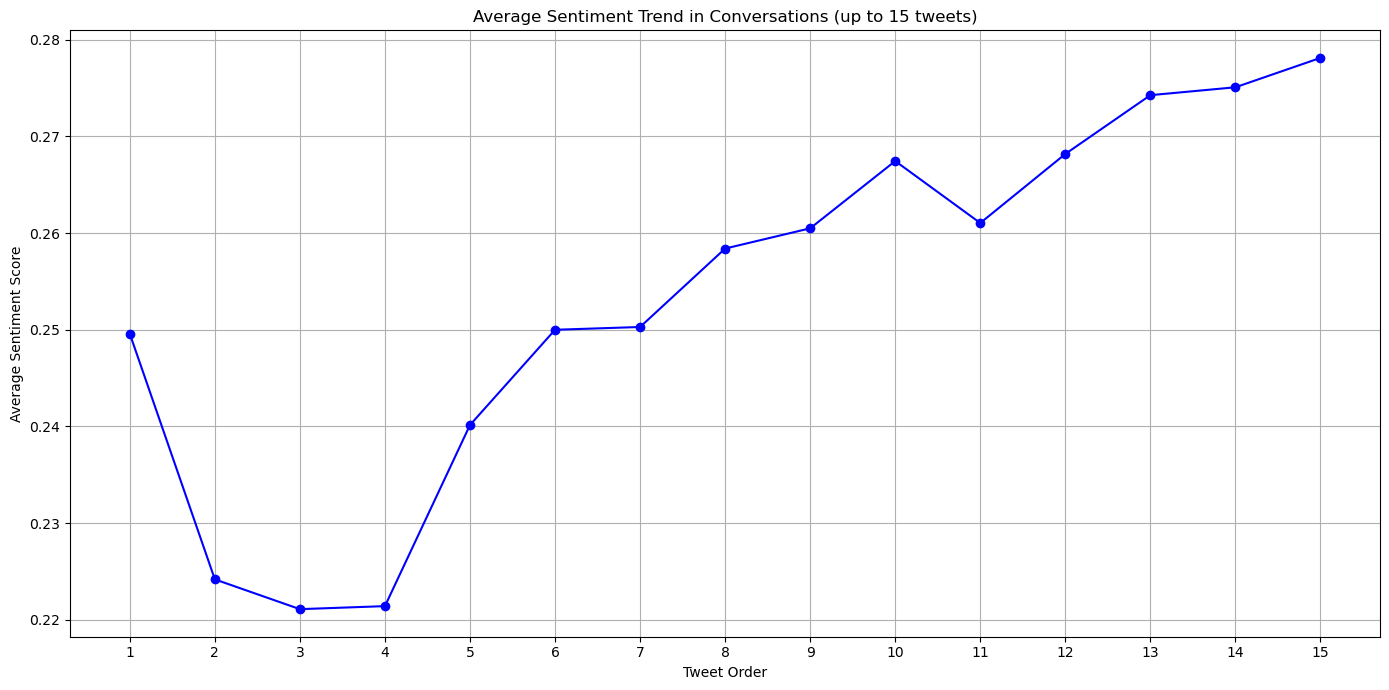

In [27]:
# Ensure the 'created_at' column is in datetime format
virgin_tweets_df['created_at'] = pd.to_datetime(virgin_tweets_df['created_at'])

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to the 'filtered_text' and store compound score
virgin_tweets_df['compound'] = virgin_tweets_df['filtered_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Group tweets by conversation thread using 'in_reply_to_status_id_str'
conversations = virgin_tweets_df.groupby('in_reply_to_status_id_str')

# Initialize a list to store conversation sentiments
conversation_sentiments = []

# Analyze sentiment evolution in all conversations
for conversation_id, conversation in conversations:
    if conversation_id:  # Exclude tweets that are not replies
        sorted_conversation = conversation.sort_values('created_at')
        sentiment_trend = sorted_conversation['compound'].tolist()
        conversation_sentiments.append(sentiment_trend[:15])  # Limit to first 15 tweets

# Determine the maximum length of conversations to align all sentiment trends
max_length = 15

# Pad the sentiment trends with NaN values to ensure equal length
padded_sentiments = [np.pad(trend, (0, max_length - len(trend)), 'constant', constant_values=np.nan) for trend in conversation_sentiments]

# Convert to DataFrame for easier averaging
sentiment_trends_df = pd.DataFrame(padded_sentiments)

# Calculate the mean sentiment at each position
average_sentiment_trend = sentiment_trends_df.mean(axis=0)

# Smooth the line using rolling mean
smooth_sentiment_trend = average_sentiment_trend.rolling(window=3, min_periods=1).mean()

# Plot the average sentiment trend
plt.figure(figsize=(14, 7))
plt.plot(range(1, max_length + 1), smooth_sentiment_trend, marker='o', linestyle='-', color='b')
plt.title('Average Sentiment Trend in Conversations (up to 15 tweets)')
plt.xlabel('Tweet Order')
plt.ylabel('Average Sentiment Score')
plt.xticks(range(1, max_length + 1))
plt.grid(True)
plt.tight_layout()
plt.show()
